Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [1]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## The *Nim* and *Nimply* classes

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [3]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return bool(sum(self._rows) > 0)

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
    
    def n_possible_moves(self) -> int:
        return sum(self._rows)

## Sample (and silly) startegies 

In [4]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

In [5]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [6]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [7]:
logging.getLogger().setLevel(logging.INFO)

strategy = (gabriele, pure_random)

nim = Nim(6)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")

INFO:root:init : <1 3 5 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 7 9 11>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=2)
INFO:root:status: <0 3 5 7 7 11>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=3)
INFO:root:status: <0 0 5 7 7 11>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 0 5 7 6 11>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=5)
INFO:root:status: <0 0 0 7 6 11>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=2)
INFO:root:status: <0 0 0 7 4 11>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=7)
INFO:root:status: <0 0 0 0 4 11>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=4)
INFO:root:status: <0 0 0 0 0 11>
INFO:root:ply: player 0 plays Nimply(row=5, num_objects=11)
INFO:root:status: <0 0 0 0 0 0>
INFO:root:status: Player 1 won!


# Our Solution

In [8]:
NUM_MATCHES = 1000
NIM_SIZE = 5
N_GAMES_SIMULATED_PER_MOVE = 100

nim = Nim(NIM_SIZE)

## Methods

In [9]:
def generate_all_possible_moves(state: Nim) -> list:
    return [Nimply(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]

def max_num_objects(state: Nim) -> dict:
    return {r: c for r, c in enumerate(state.rows)}

def sample_random_move(state: Nim) -> Nimply:
    possible_moves = generate_all_possible_moves(state)
    move = random.choice(range(len(possible_moves)))
    return possible_moves[move], move

def sampler(state: Nim) -> Nimply:
    return sample_random_move(state=state)[0]

def generate_game(state: Nim) -> tuple:
    strategy = (sampler, pure_random)
    temp_state = deepcopy(state)
    first_move = None 
    player = 0 
    while temp_state:
        ply = strategy[player](temp_state)
        first_move = ply if first_move is None else first_move
        temp_state.nimming(ply)
        player = 1 - player
    return (first_move, player)

def generate_games(state: Nim, n: int = 1000) -> list:
    return [generate_game(state=state) for _ in range(n)]

def choose_best_move(state: Nim, n_games: int = 1000) -> Nimply:
    games = generate_games(state=state, n=n_games)
    winning_moves = np.array([game[0] for game in games if game[1] == 0])
    total_moves = np.array([game[0] for game in games])
    winning_moves, winning_count = np.unique(winning_moves, return_counts=True, axis=0)
    total_moves, total_count = np.unique(total_moves, return_counts=True, axis=0)

    best_move_val = -1 
    best_move_index = -1

    for i, move in enumerate(total_moves):
        for j, move2 in enumerate(winning_moves):
            if (move == move2).all():
                winrate = winning_count[j]/total_count[i]
                if winrate > best_move_val:
                    best_move_val = winrate
                    best_move_index = i
                break 
    
    best_move = total_moves[best_move_index]

    return Nimply(best_move[0], best_move[1])

def our_strategy(state: Nim) -> Nimply:
    return choose_best_move(state=state, n_games=N_GAMES_SIMULATED_PER_MOVE)

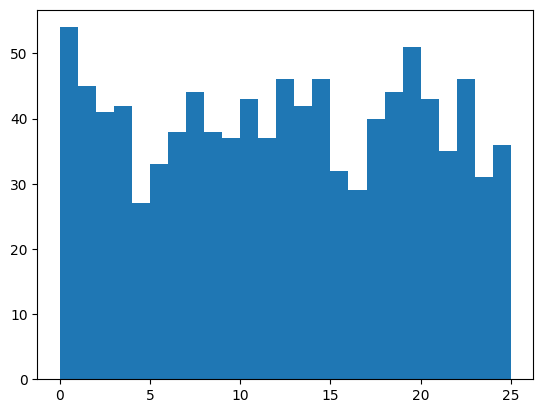

In [10]:
def plot_hist_moves(state: Nim) -> Nimply:
    list = []
    for i in range(1000):
        _, num = sample_random_move(state=state)
        list.append(num)

    plt.hist(list, bins=state.n_possible_moves(), range=(0,state.n_possible_moves())) 
    plt.show()

plot_hist_moves(nim)
# STD makes sense between 2 and 6

## Comparison between our solution and the ones provided

#### Oversimplified match

In [11]:
logging.getLogger().setLevel(logging.INFO)

strategy = (our_strategy, gabriele)

nim = Nim(6)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")

INFO:root:init : <1 3 5 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=3)
INFO:root:status: <1 3 2 7 9 11>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 2 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=2)
INFO:root:status: <0 1 2 7 9 11>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 0 2 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=7)
INFO:root:status: <0 0 2 0 9 11>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=2)
INFO:root:status: <0 0 0 0 9 11>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=9)
INFO:root:status: <0 0 0 0 0 11>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=11)
INFO:root:status: <0 0 0 0 0 0>
INFO:root:status: Player 0 won!


### Our Solution vs. Pure Random

In [16]:
def evaluate(strategy1, strategy2):
    """evaluate put a first strategy versus a second one for a certain number of times, the results is the ratio 
    between the won matches and the total number of played matches"""
    players = (strategy1, strategy2)
    won = 0

    for _ in tqdm(range(NUM_MATCHES)):
        nim = Nim(NIM_SIZE)
        player = random.randint(0,1) # make a random start
        while nim:
            ply = players[player](nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 0:
            won += 1
    return round(won / NUM_MATCHES, 2)

ev_optimalvsexpert = evaluate(our_strategy, pure_random)
print(f"Our Solution vs Opponent => {ev_optimalvsexpert}")

100%|██████████| 1000/1000 [00:31<00:00, 31.72it/s]

Our Solution vs Opponent => 0.93


### Our Solution vs. Gabriele's Solution

In [13]:
def evaluate(strategy1, strategy2):
    """evaluate put a first strategy versus a second one for a certain number of times, the results is the ratio 
    between the won matches and the total number of played matches"""
    players = (strategy1, strategy2)
    won = 0

    for _ in tqdm(range(NUM_MATCHES)):
        nim = Nim(NIM_SIZE)
        player = random.randint(0,1) # make a random start
        while nim:
            ply = players[player](nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 0:
            won += 1
    return round(won / NUM_MATCHES, 2)

ev_optimalvsexpert = evaluate(our_strategy, gabriele)
print(f"Our Solution vs Opponent => {ev_optimalvsexpert}")

100%|██████████| 1000/1000 [00:25<00:00, 39.59it/s]

Our Solution vs Opponent => 0.95
